# Project: Image Classification and Regression
## MVA - CentraleSupelec
## Deep Learning Course, Vincent Lepetit

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input, UpSampling2D, concatenate
from keras.optimizers import Adam,SGD
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [9]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


##  Simple Classification

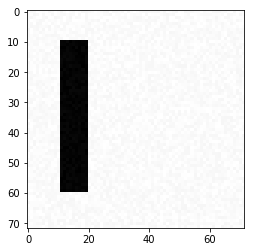

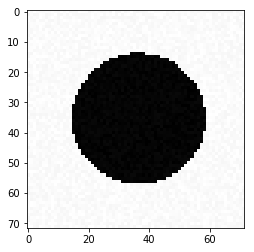

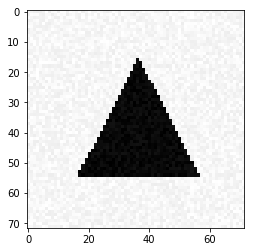

In [130]:
im = generate_a_rectangle(10, True)
plt.figure()
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.figure()
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.figure()
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [128]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = utils.to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [148]:
print(X_train.shape)
print(Y_train.shape)

(300, 5184)
(300, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0.

In [191]:
model = Sequential([
Dense(3, activation = 'softmax')])
sgd = SGD(lr=0.01,
decay=1e-6, momentum=0.9,
nesterov=True)
adam = Adam()
model.compile(loss='categorical_crossentropy',
optimizer=adam)


In [158]:
model.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 1.7130
Epoch 2/100
300/300 [==============================] - 0s 51us/step - loss: 0.6710
Epoch 3/100
300/300 [==============================] - 0s 59us/step - loss: 0.5277
Epoch 4/100
300/300 [==============================] - 0s 62us/step - loss: 0.4521
Epoch 5/100
300/300 [==============================] - 0s 54us/step - loss: 0.3568
Epoch 6/100
300/300 [==============================] - 0s 62us/step - loss: 0.3267
Epoch 7/100
300/300 [==============================] - 0s 54us/step - loss: 0.3073
Epoch 8/100
300/300 [==============================] - 0s 63us/step - loss: 0.3614
Epoch 9/100
300/300 [==============================] - 0s 55us/step - loss: 0.2195
Epoch 10/100
300/300 [==============================] - 0s 50us/step - loss: 0.1696
Epoch 11/100
300/300 [==============================] - 0s 50us/step - loss: 0.1683
Epoch 12/100
300/300 [==============================] - 0s 43us/step - loss: 0.1415
Ep

In [159]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)


array([[0., 1., 0.]], dtype=float32)

In [160]:
[X_test,V] = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

In [161]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

## Visualization of the Solution

(5184, 3)


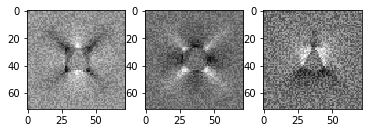

In [174]:
weights = model.get_weights()
fig=plt.figure()
print(weights[0].shape)
fig.add_subplot(1, 3, 1)
plt.imshow(weights[0][:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
fig.add_subplot(1, 3, 2)
plt.imshow(weights[0][:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
fig.add_subplot(1, 3, 3)
plt.imshow(weights[0][:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## A More Difficult Classification Problem


In [226]:
[X_train, Y_train] = generate_dataset_classification(5000, 20, True)
Y_train = utils.to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [184]:
model = Sequential([
Dense(3, activation = 'softmax')])
adam = Adam()
model.compile(loss='categorical_crossentropy',
optimizer=adam)

In [185]:
model.fit(X_train, Y_train, epochs=100, batch_size=32)


Epoch 1/100
300/300 [==============================] - 1s 2ms/step - loss: 2.5337
Epoch 2/100
300/300 [==============================] - 0s 69us/step - loss: 1.4113
Epoch 3/100
300/300 [==============================] - 0s 58us/step - loss: 1.1981
Epoch 4/100
300/300 [==============================] - 0s 68us/step - loss: 1.2096
Epoch 5/100
300/300 [==============================] - 0s 60us/step - loss: 1.0331
Epoch 6/100
300/300 [==============================] - 0s 56us/step - loss: 1.0261
Epoch 7/100
300/300 [==============================] - 0s 51us/step - loss: 0.9241
Epoch 8/100
300/300 [==============================] - 0s 52us/step - loss: 0.9182
Epoch 9/100
300/300 [==============================] - 0s 57us/step - loss: 0.9045
Epoch 10/100
300/300 [==============================] - 0s 55us/step - loss: 0.9917
Epoch 11/100
300/300 [==============================] - 0s 51us/step - loss: 0.9607
Epoch 12/100
300/300 [==============================] - 0s 49us/step - loss: 1.0178
Ep

In [189]:
[X_test, Y_test] = generate_test_set_classification()
model.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 691us/step


1.2438903617858887

In [228]:
modelconv = Sequential([
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(3, activation = 'softmax')])
modelconv.compile(loss='categorical_crossentropy',
optimizer=adam)

In [230]:
X_train_conv = X_train.reshape((X_train.shape[0],IMAGE_SIZE,IMAGE_SIZE,1))

In [231]:
modelconv.fit(X_train_conv, Y_train, epochs=100, batch_size=32)

Epoch 1/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.8087A: 0s - loss: 
Epoch 2/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.4308
Epoch 3/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.2859
Epoch 4/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.2278
Epoch 5/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.1547
Epoch 6/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.1259
Epoch 7/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.1063
Epoch 8/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.1037
Epoch 9/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.0961
Epoch 10/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.0932A: 0s - lo
Epoch 11/100
5000/5000 [==============================] - 5s 1ms/step - loss: 0.0824
Epoch 12/100
5000/5000 [==========================

In [224]:
[X_test_conv, Y_test_conv] = generate_test_set_classification()
X_test_conv = X_test_conv.reshape((X_test_conv.shape[0],IMAGE_SIZE,IMAGE_SIZE,1))

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [232]:
modelconv.evaluate(X_test_conv, Y_test_conv)

300/300 [==============================] - 0s 2ms/step


0.2618756318092346

## A regression problem

In [84]:
[X_train_r, Y_train_reg] = generate_dataset_regression(300, 20)
X_train_reg = X_train_r.reshape((X_train_r.shape[0],IMAGE_SIZE,IMAGE_SIZE,1))

Creating data:
0
100
200


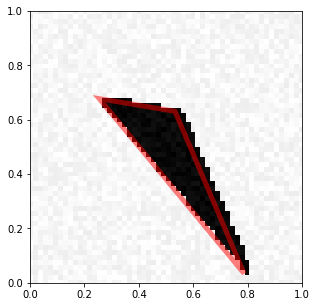

In [85]:
visualize_prediction(X_train[0], Y_train[0])

In [86]:
Y_train[0]

array([0.53318515, 0.63086882, 0.78739526, 0.0339553 , 0.25444269,
       0.6773738 ])

In [87]:
modelregression = Sequential([
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(6)])
adam = Adam()
modelregression.compile(loss='mean_squared_error',
optimizer=adam)

In [88]:

modelregression.fit(X_train_reg, Y_train_reg, epochs=50, batch_size=32)

Epoch 1/50
300/300 [==============================] - 1s 4ms/step - loss: 0.1298
Epoch 2/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0820
Epoch 3/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0668
Epoch 4/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0624
Epoch 5/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0573
Epoch 6/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0554
Epoch 7/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0535
Epoch 8/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0518
Epoch 9/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0484
Epoch 10/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0473
Epoch 11/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0449
Epoch 12/50
300/300 [==============================] - 1s 2ms/step - loss: 0.0437
Epoch 13/50
300/300 [====

In [89]:
[X_test_r, Y_test_reg] = generate_test_set_regression()
X_test_reg = X_test_r.reshape((X_test_r.shape[0],IMAGE_SIZE,IMAGE_SIZE,1))

Creating data:
0
100
200


In [90]:
modelregression.evaluate(X_test_reg, Y_test_reg)

300/300 [==============================] - 0s 1ms/step


0.0904676452279091

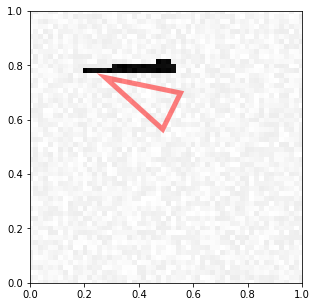

In [91]:
visualize_prediction(X_test_reg[1], modelregression.predict(X_test_reg)[1])

In [117]:
inputs = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))

conv1a = Conv2D(16, (5, 5), activation='relu')(inputs)
conv1b = Conv2D(16, (5, 5), activation='relu')(conv1a)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1b)

conv2a = Conv2D(32, (3, 3), activation='relu')(pool1)
conv2b = Conv2D(32, (3, 3), activation='relu')(conv2a)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2b)

conv3a = Conv2D(64, (3, 3), activation='relu')(pool2)
conv3b = Conv2D(64, (3, 3), activation='relu')(conv3a)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3b)

up4 = UpSampling2D(size = (2,2))(pool3)
conv4 = Conv2D(64, (3, 3), activation='relu')(up4)
up5 = UpSampling2D(size=(2, 2))(up4)
conv5 = Conv2D(16,(2, 2), activation='relu')(up5)
merge5 = concatenate([conv2,conv5])
up6 = UpSampling2D(size=(2, 2))(merge5)
conv6 = Conv2D(16, (5, 5), activation='relu')(up6)
merge6 = concatenate([conv1,conv6],axis=3)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = 'adam',
loss = 'mean_squared_error')



ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 32, 32, 32), (None, 19, 19, 16)]